In [11]:
from copy import deepcopy
from libemg.filtering import Filter
from libemg.feature_extractor import FeatureExtractor
import numpy as np
from sklearn.cluster import KMeans
import itertools
import os
from matplotlib import pyplot as plt

from emgstatedetect.providers.biopatrec.biopatrec_classes import BioPatRecRecordingDataset
from emgstatedetect.providers.biopatrec.biopatrec_libemg_adapters.adapter_10mov4chFU_AFEs import Device, AnalogFrontEnd_UntargetedForearm
from emgstatedetect.visualizations.plots import plot_multisubject_multiclass_multichannel
from emgstatedetect.state_detection.class_asignment import map_window_labels_to_samples_by_voting, assign_class_to_labels

In [2]:
dataset = BioPatRecRecordingDataset('10mov4chFU_AFEs', '10mov4chFU_AFEs', persist_source=True)

TIADS1299_dataset = AnalogFrontEnd_UntargetedForearm(dataset_info=dataset.info, device=Device.ADS)

TIADS1299_dataset.prepare_data()
TIADS1299_dataset.filter_data()

2025-06-02 14:28:45 [INFO] biopatrec_classes.__init__: Initializing BioPatRecRecordingDataset for: 10mov4chFU_AFEs
2025-06-02 14:28:45 [INFO] biopatrec_classes.__init__: Local folder '10mov4chFU_AFEs' exists and contains mat files. Loading existing .mat files.


Local folder path: /workspaces/EMGStateDetect/10mov4chFU_AFEs
80 data files fetched out of 80 files.


In [3]:
WINDOW_SECONDS_SIZE = 0.25
WINDOW_SECONDS_STEP = 0.05

window_samples_size = int(TIADS1299_dataset.sampling * WINDOW_SECONDS_SIZE)
window_samples_step = int(TIADS1299_dataset.sampling * WINDOW_SECONDS_STEP)

In [ ]:
unique_subjects = list(np.unique(np.array(TIADS1299_dataset.odh.subjects)))
unique_classes = list(np.unique(np.array(TIADS1299_dataset.odh.classes)))

combinations = list(itertools.product(unique_subjects, unique_classes))

for subject, class_ in combinations:
    odh = TIADS1299_dataset.odh.isolate_data("subjects", [subject])
    odh = odh.isolate_data("classes", [class_])

    windows, metadata = odh.parse_windows(window_samples_size, window_samples_step, metadata_operations=None)

    fe = FeatureExtractor()
    features = fe.extract_feature_group('HTD', windows, array=True)

    kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')

    # Fit and predict cluster labels
    labels = kmeans.fit_predict(features)

    samples_label = map_window_labels_to_samples_by_voting(labels, window_samples_size, window_samples_step, odh.data[0].shape[0])

    classes_dict = assign_class_to_labels(odh.data[0], samples_label)


    os.makedirs(f'/workspaces/EMGStateDetect/10mov4chFU_AFEs/ADS/clean/Subject_{subject}', exist_ok=True)
    np.savetxt(f'/workspaces/EMGStateDetect/10mov4chFU_AFEs/ADS/clean/Subject_{subject}/C_{class_}.csv', classes_dict['Action']['data'], delimiter=',')


(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)
(36000,)


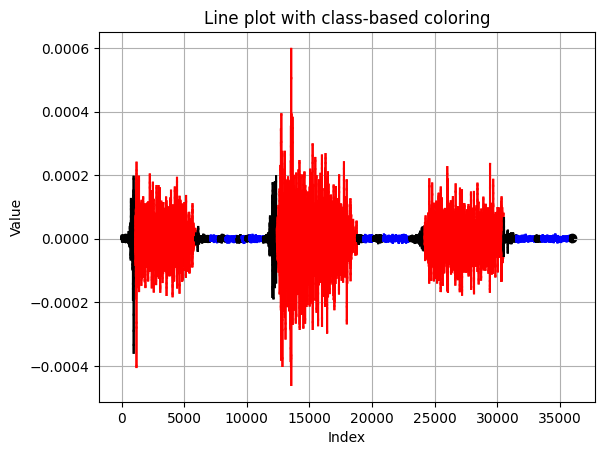

In [82]:
import numpy as np
import matplotlib.pyplot as plt

dbscan = DBSCAN(eps=14, min_samples=5)
# Fit and predict cluster labels
labels = dbscan.fit_predict(features)
samples_label = map_window_labels_to_samples_by_voting(labels, window_samples_size, window_samples_step, odh.data[0].shape[0])
# Example data
values = odh.data[0][:,3]
classes = samples_label  # class for each point

# Assign a color to each class
class_colors = {0: 'red', 1: 'blue'}
colors = [class_colors.get(c, 'black') for c in classes]

# Plotting each point with a class-based color
for i in range(len(values)-1):
    plt.plot([i, i+1], [values[i], values[i+1]], color=colors[i])

# Plot the final point for visibility
plt.scatter(len(values)-1, values[-1], color=colors[-1])

plt.title("Line plot with class-based coloring")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [46]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=15, min_samples=5)
# Fit and predict cluster labels
labels = dbscan.fit_predict(features)
labels

array([-1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,
       -1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
       -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

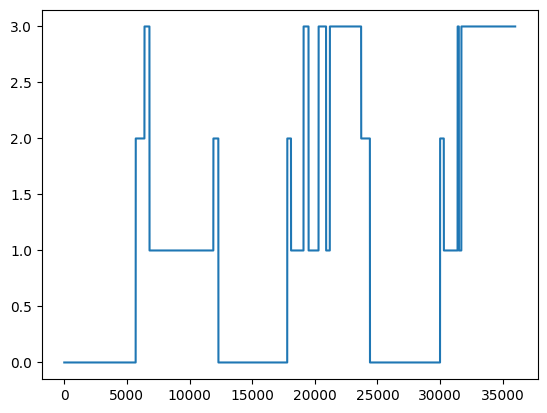

In [20]:
plt.plot(samples_label)

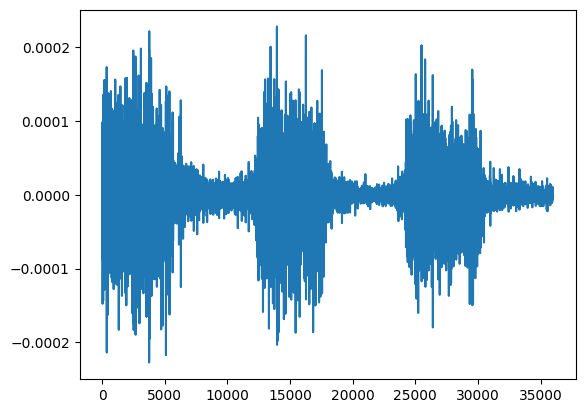

In [21]:
plt.plot(odh.data[0][:,0])

## Clean signals

In [106]:
TIADS1299_dataset.prepare_data(is_clean=True)

80 data files fetched out of 80 files.


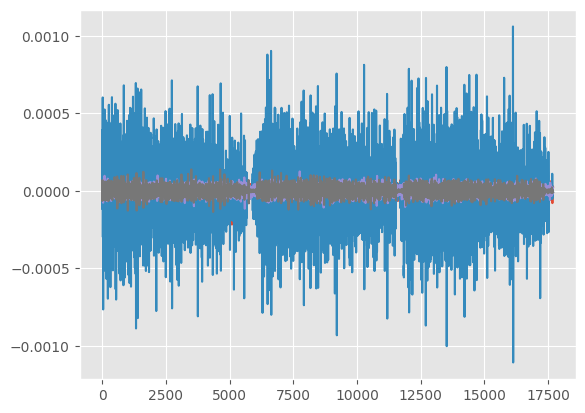

In [145]:
from matplotlib import pyplot as plt

odh = TIADS1299_dataset.clean_odh.isolate_data("subjects", [0])
odh = odh.isolate_data("classes", [0,1])

plt.plot(odh.data[0])

In [146]:
odh = TIADS1299_dataset.clean_odh.isolate_data("subjects", [1])
odh = odh.isolate_data("classes", [0,1])

In [147]:
windows, metadata = odh.parse_windows(window_samples_size, window_samples_step)
fe = FeatureExtractor()

train_features = fe.extract_feature_group('HTD', windows, array=True)
train_labels = metadata['classes']

In [153]:
from libemg.emg_predictor import EMGClassifier

clf = EMGClassifier('LDA')

feature_set = {
    'training_features': train_features,
    'training_labels': train_labels
}
clf.fit(feature_set)

In [154]:
odh = TIADS1299_dataset.clean_odh.isolate_data("subjects", [4])
odh = odh.isolate_data("classes", [0,1])

In [155]:
windows, metadata = odh.parse_windows(window_samples_size, window_samples_step)
fe = FeatureExtractor()

test_features = fe.extract_feature_group('HTD', windows, array=True)
test_labels = metadata['classes']

{'CA': 0.7816091954022989, 'AER': 0.2183908045977011, 'INS': 0.08908045977011494}


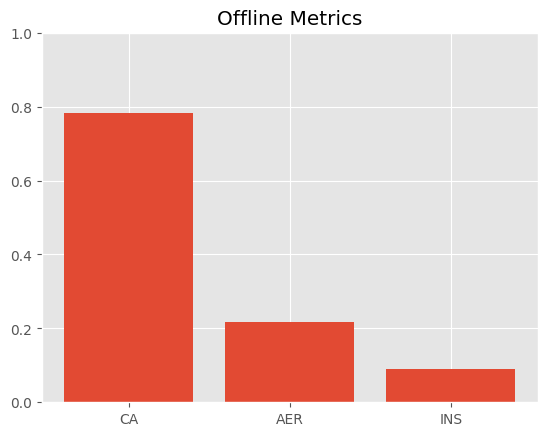

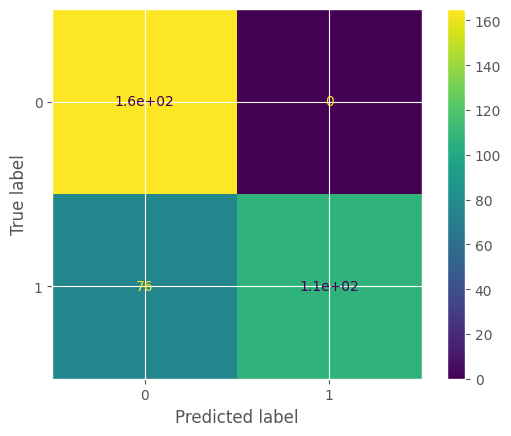

In [156]:
from libemg.offline_metrics import OfflineMetrics

om = OfflineMetrics()

clf_predictions, _ = clf.run(test_features)
null_label = 2  # value corresponding to no motion - defined based on the dataset
classification_metrics = om.extract_common_metrics(test_labels, clf_predictions, null_label=null_label)    # extracts some common classification metrics
print(classification_metrics)
om.visualize(classification_metrics)

# Visualize confusion matrix
mat = om.get_CONF_MAT(test_labels, clf_predictions)
om.visualize_conf_matrix(mat)